### EDA

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [8]:
import os
print(os.getcwd())
# os.chdir('..')
print(os.getcwd())

c:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives
c:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives


Old dataset (kept for reference)

In [9]:
df = pd.read_csv("Data/gsod_station_722860.csv")

Checking NAs

In [41]:
# Show number of missing values per column
print(df.isna().sum())

# Or as a percentage of total
print(df.isna().mean() * 100)


Unnamed: 0    0
date          0
temp          0
max           0
min           0
dtype: int64
Unnamed: 0    0.0
date          0.0
temp          0.0
max           0.0
min           0.0
dtype: float64


In [42]:
temp_cols = ['temp', 'max', 'min']
print(df[temp_cols].isna().sum())


temp    0
max     0
min     0
dtype: int64


Checking Outliers

In [43]:
df['date'] = pd.to_datetime(df['date'])

In [45]:
max_outliers = df[df['max'] > 50]
print(max_outliers)

       Unnamed: 0       date   temp      max   min  year
13463       13463 1969-12-15   8.78  5537.72 -2.78  1969
14722       14722 1973-05-27  19.33  5537.72  7.72  1973
15607       15607 1975-10-29  16.56  5537.72  7.22  1975
28815       28815 2011-12-28   8.22  5537.72 -2.50  2011
28818       28818 2011-12-31  11.56  5537.72  1.72  2011
31007       31007 2017-12-28  11.44  5537.72  1.22  2017
32089       32089 2020-12-20   8.89  5537.72 -1.78  2020


In [46]:
min_outliers = df[df['min'] > 50]
print(min_outliers)

       Unnamed: 0       date   temp    max      min  year
7               7 1933-01-08  14.44  23.50  5537.72  1933
164           164 1933-06-14  33.17  38.89  5537.72  1933
12673       12673 1967-10-17  22.61  35.50  5537.72  1967
22929       22929 1995-11-15  11.83  23.78  5537.72  1995


Removing Outliers

In [ ]:
import numpy as np

# Replace outliers with NaN for MAX and MIN
threshold_max = 100   # adjust according to realistic limits for your dataset

df.loc[df['max'] > threshold_max, 'max'] = np.nan
df.loc[df['min'] > threshold_max, 'min'] = np.nan

# Optionally, interpolate missing values
df['max'] = df['max'].interpolate(method='linear')
df['min'] = df['min'].interpolate(method='linear')

# Check the stats to confirm values are now within a realistic range
print(df[['date', 'max', 'min']].describe())

                                date           max           min
count                          33651  33651.000000  33651.000000
mean   1979-02-25 22:18:40.085584320     25.608117      9.812687
min              1933-01-01 00:00:00      3.000000     -8.280000
25%              1956-02-16 12:00:00     20.000000      5.610000
50%              1979-02-28 00:00:00     25.500000     10.000000
75%              2002-03-12 12:00:00     31.720000     13.890000
max              2025-03-31 00:00:00     46.500000     34.110000
std                              NaN      7.414279      5.632309


New dataset

In [10]:
import os

# View current working directory
print("Current working directory:", os.getcwd())

# Change directory to the desired folder
new_directory = r"C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives\Data"
os.chdir(new_directory)

# Confirm the directory change
print("New working directory:", os.getcwd())


Current working directory: c:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives
New working directory: C:\Users\giamb\OneDrive\Documents\2 Uni\Associations\4 Minerva\1 Weather Derivatives\Minerva---Weather-Derivatives\Data


In [6]:
df = pd.read_csv("full_cleaned_data.csv")

Checking Average, Max, Min Temperature Trends Over the Years

           mean        max        min
year                                 
1933  20.335956  24.474238  12.238248
1934  21.830904  25.949918  13.858055
1935  20.128548  23.932411  12.612110
1936  17.528989  25.632623  10.377842
1937  16.304521  25.044137   9.338137
...         ...        ...        ...
2020  17.449317  28.056417   7.640164
2021  17.868956  27.377500   9.182555
2022  18.536164  27.958274  10.072438
2023  16.591973  25.499260   8.533973
2024  17.400109  27.087541   8.751421

[92 rows x 3 columns]


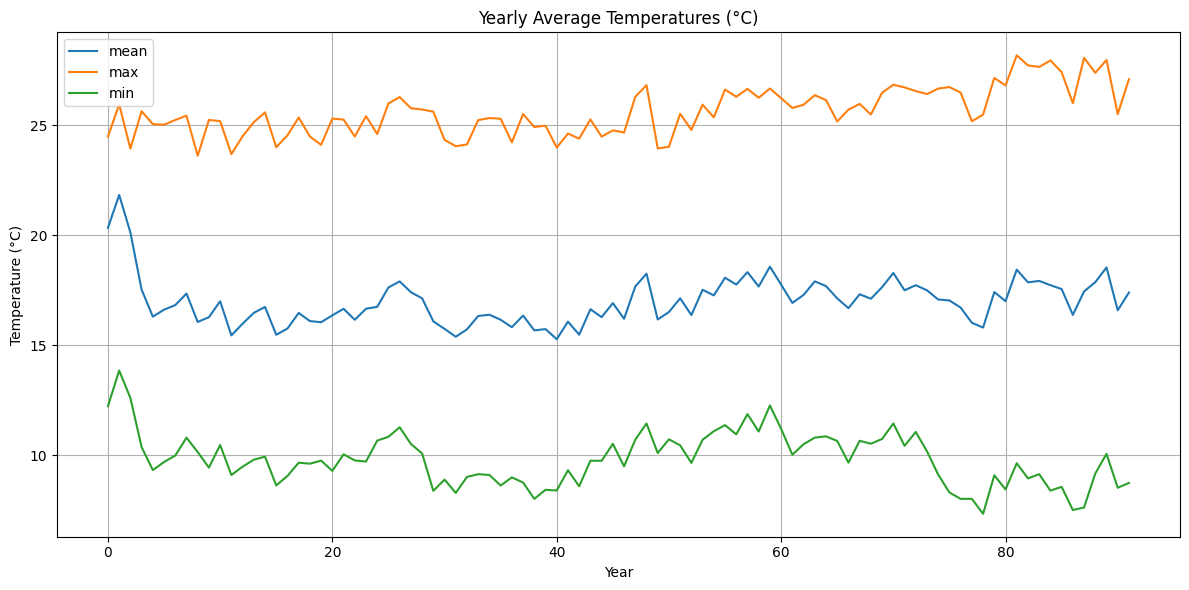

In [7]:
# Extract year for grouping
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
temp_cols = ['mean', 'max', 'min']

# Group by year and calculate mean
yearly_trends = df.groupby('year')[temp_cols].mean()
yearly_trends = yearly_trends[yearly_trends.index < 2025]
print(yearly_trends)
yearly_trends.reset_index(inplace=True)


plt.figure(figsize=(12, 6))
for col in temp_cols:
    plt.plot(yearly_trends.index, yearly_trends[col], label=col)

plt.title("Yearly Average Temperatures (°C)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Checking Difference Between Max and Min Temperature Over the Years

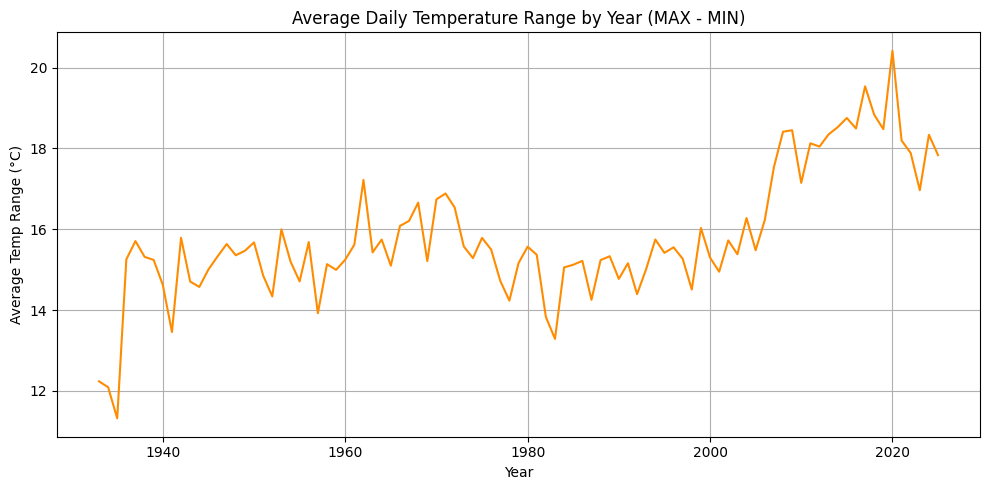

In [8]:
# Add a new column for the daily range
df['temp_range'] = df['max'] - df['min']

# Group by year and calculate average range
temp_range_by_year = df.groupby('year')['temp_range'].mean()

# Plot the average temp range
plt.figure(figsize=(10, 5))
plt.plot(temp_range_by_year.index, temp_range_by_year.values, color='darkorange')
plt.title("Average Daily Temperature Range by Year (MAX - MIN)")
plt.xlabel("Year")
plt.ylabel("Average Temp Range (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()


year
1933    361
1934    365
1935    365
1936    366
1937    365
1938    365
1939    365
1940    366
1941    335
1942    365
1943    365
1944    366
1945    365
1946    365
1947    365
1948    366
1949    365
1950    365
1951    365
1952    366
1953    365
1954    365
1955    365
1956    366
1957    365
1958    365
1959    365
1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    364
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365

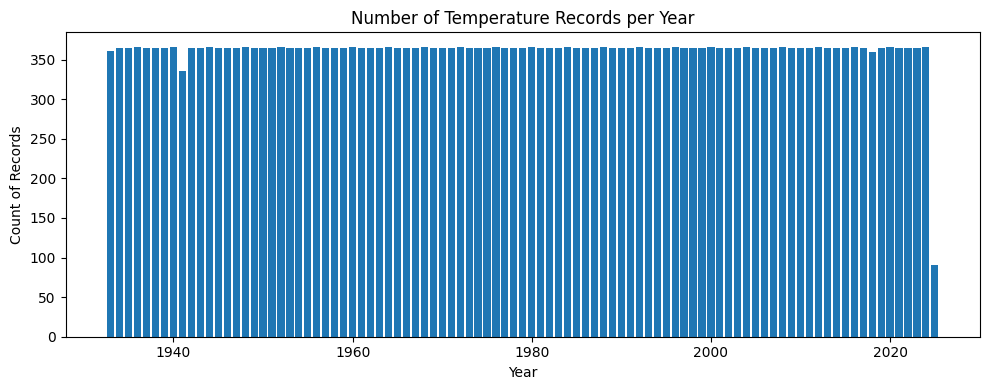

In [9]:
# Count number of measurements per year
freq_by_year = df.groupby('year').size()
print(freq_by_year.to_string())

# Plot number of records per year
plt.figure(figsize=(10, 4))
plt.bar(freq_by_year.index, freq_by_year.values)
plt.title("Number of Temperature Records per Year")
plt.xlabel("Year")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

### Test-Train Split

In [16]:
# Create train and test sets for the selected features (without shuffling for time series)
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)

print("Train dataset shape:", df_train.shape)
print("Test dataset shape:", df_test.shape)

Train dataset shape: (26920, 6)
Test dataset shape: (6731, 6)


### Feature Scaling

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = ['mean', 'max', 'min']
df_train_scaled = df_train.copy()
scaler = MinMaxScaler()
df_train_scaled[features] = scaler.fit_transform(df_train_scaled[features])

print("Scaled data summary:")
print(df_train_scaled[features].describe())

Scaled data summary:
               mean           max           min
count  26920.000000  26920.000000  26920.000000
mean       0.422704      0.523292      0.434508
std        0.148275      0.172902      0.128476
min        0.000000      0.000000      0.000000
25%        0.305475      0.384651      0.339467
50%        0.409157      0.516311      0.431234
75%        0.538275      0.659704      0.525596
max        1.000000      1.000000      1.000000


THERE IS AN ERROR PROB IN THE GRAPHING

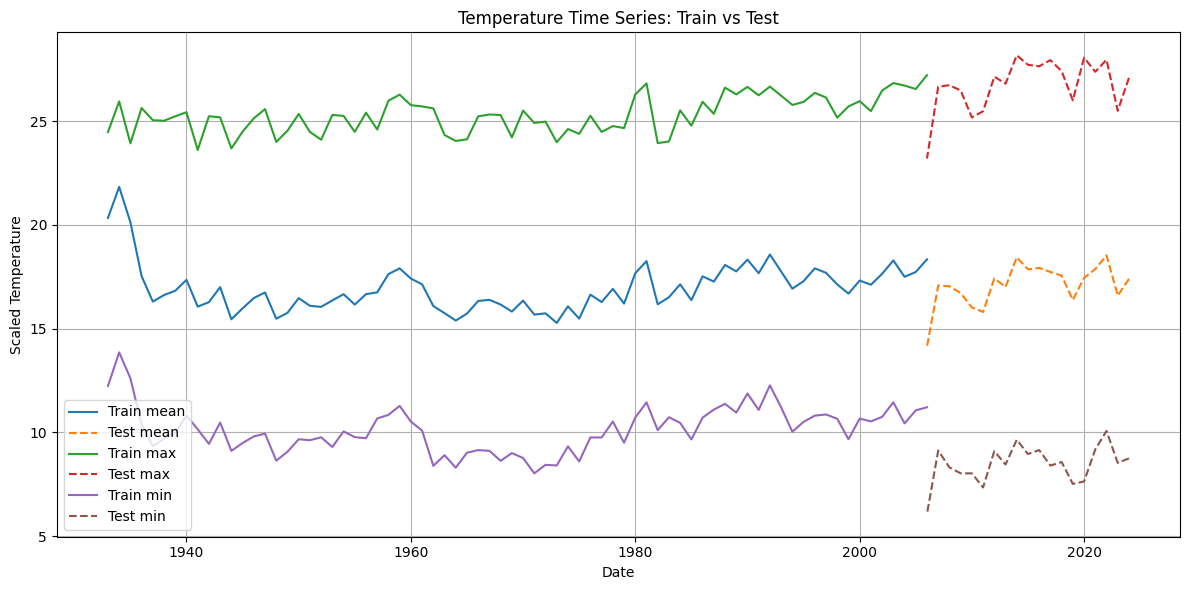

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# Define temp_cols as the list of features.
temp_cols = ['mean', 'max', 'min']

# Group by year and calculate the mean.
yearly_trends_train = df_train.groupby('year')[temp_cols].mean()
yearly_trends_train = yearly_trends_train[yearly_trends_train.index < 2025]


# Optionally, compute differences between consecutive years.
# yearly_trends_train['temp_diff'] = yearly_trends_train['temp'].diff()

yearly_trends_test = df_test.groupby('year')[temp_cols].mean()
yearly_trends_test = yearly_trends_test[yearly_trends_test.index < 2025]

# Turn off or on to check the test set
# yearly_trends_test = yearly_trends_test[::-1]

# yearly_trends_test['temp_diff'] = yearly_trends_test['temp'].diff()

plt.figure(figsize=(12, 6))
for col in temp_cols:
    # Plot training data (using the date column for the x-axis)
    plt.plot(yearly_trends_train.index, yearly_trends_train[col], label=f'Train {col}')
    # Plot testing data
    plt.plot(yearly_trends_test.index, yearly_trends_test[col], label=f'Test {col}', linestyle='--')

plt.title("Temperature Time Series: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Correct graphing without taking the mean, just daily

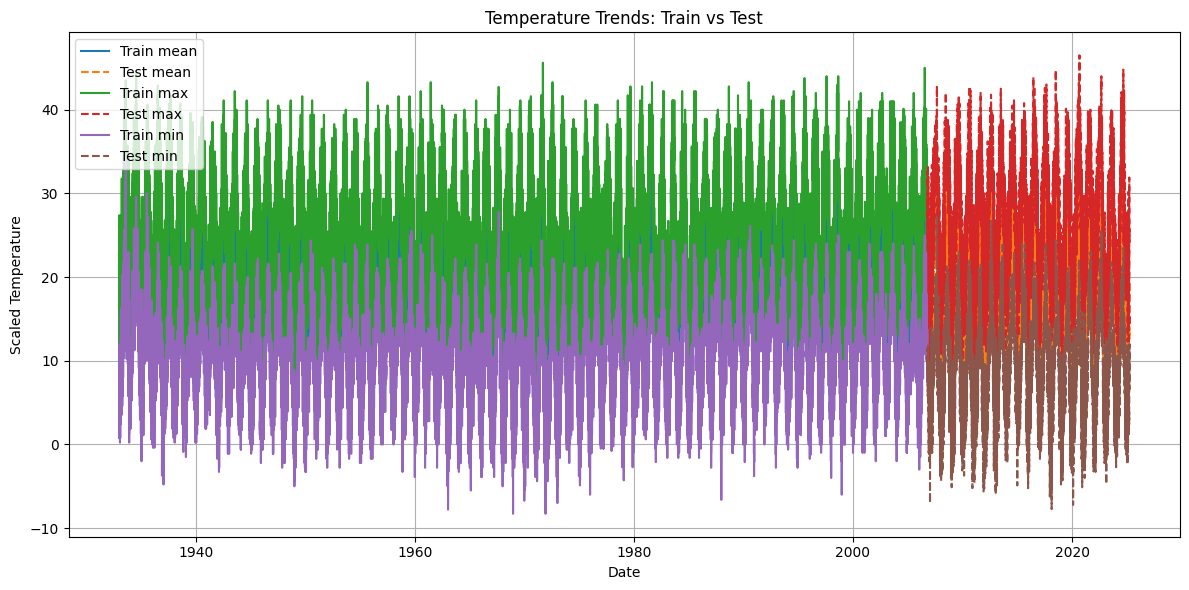

In [33]:
# Assume df_train and df_test still have the date column (set as datetime).
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

plt.figure(figsize=(12,6))
for col in temp_cols:
    plt.plot(df_train['date'], df_train[col], label=f'Train {col}')
    plt.plot(df_test['date'], df_test[col], label=f'Test {col}', linestyle='--')
    
plt.title("Temperature Trends: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LSTM Training Alessandro

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scikeras.wrappers import KerasRegressor

# Split data
train_size = int(len(df) * 0.9)
train_data, test_data = df[:train_size], df[train_size:]

# Scale data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'

In [147]:
# Data preprocessing
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data) - 1):
        seq_x = data[i - seq_length:i]

        xs.append(seq_x)
        ys.append(data[i,0])
    return np.array(xs), np.array(ys)


SEQ_LENGTH = 10

X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

KeyError: (10, 0)

In [ ]:
def build_lstm_model(OPTIMIZER='adam', LOSS = 'mse', METRICS = ''):
    # Modify the Network Structure
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 3)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Predicting 3 features

    if METRICS != '':
        model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
    else:
        model.compile(optimizer=OPTIMIZER, loss=LOSS)

    return model

In [ ]:
# Callbacks
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Wrap in KerasRegressor
lstm = KerasRegressor(model=build_lstm_model, verbose=0)

randomized = True

lstm = KerasRegressor(build_fn=build_lstm_model, verbose = 0)

# Define search parameters
parameters = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'model__optimizer': ['adam', 'rmsprop']
}

# Randomized search
random_search = RandomizedSearchCV(estimator=lstm, param_distributions=parameters, cv=3)

# Fit with callbacks and validation split
random_search.fit(
    X_train, y_train,
    callbacks=[checkpoint_cb, early_stopping_cb],
    validation_split=0.1
)

# parameters = {'batch_size': [16, 32, 64, 128],
#               'epochs': [100, 150],
#               'optimizer': ['adam']}

# if randomized:
#     random_search = RandomizedSearchCV(estimator=lstm, param_distributions=parameters)
#     random_search = random_search.fit(X_train, y_train)#, fit__callbacks = [checkpoint_cb, early_stopping_cb])#, fit_validation_split=.1)
# else:
#     grid_search = GridSearchCV(estimator=lstm, param_grid=parameters)
#     #grid_search = grid_search.fit(X_train, y_train, verbose = 1, callbacks = [checkpoint_cb, early_stopping_cb])

### LSTM TESTING ALESSANDRO

### LSTM Training Lorenzo

In [38]:
# Function to create sequences
def create_sequences(data, n_timesteps):
    """
    Converts time series data into sequences for LSTM training.
    
    Parameters:
    - data: numpy array of shape (n_samples, n_features)
    - n_timesteps: number of past time steps to use in each input sequence.
    
    Returns:
    - X: numpy array of input sequences with shape (n_samples - n_timesteps, n_timesteps, n_features)
    - y: numpy array of outputs with shape (n_samples - n_timesteps, n_features)
    """
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        X.append(data[i:i+n_timesteps])
        y.append(data[i+n_timesteps])
    return np.array(X), np.array(y)

# Use only the 'mean' temperature column instead of multiple columns.
# Assuming df_train_scaled is already defined and scaled.
data = df_train_scaled[['mean']].values

# Define the sequence length, e.g., using the previous 30 days
n_timesteps = 30

# Create input and output sequences from the data
X, y = create_sequences(data, n_timesteps)

print("Input shape X:", X.shape)   # Expected shape: (n_samples - n_timesteps, n_timesteps, 1)
print("Output shape y:", y.shape)    # Expected shape: (n_samples - n_timesteps, 1)


Input shape X: (26890, 30, 1)
Output shape y: (26890, 1)


In [39]:
import tensorflow as tf

# Custom learning rate schedule: lr = c / sqrt(t + 1)
class CSqrtSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, c):
        super().__init__()
        self.c = c  # The constant c

    def __call__(self, step):
        # Adding 1 to step to avoid division by zero (when t=0)
        return self.c / tf.sqrt(tf.cast(step + 1, tf.float32))
    
    def get_config(self):
        return {"c": self.c}


In [42]:
c_value = 0.1  # You can adjust this constant as needed
lr_schedule = CSqrtSchedule(c=c_value)
n_features = X.shape[2]  
n_outputs = y.shape[1]   
def create_model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
    # model.add(LSTM(50, return_sequences=True, input_shape=(n_timesteps, n_features)))
    model.add(LSTM(50))
    model.add(Dense(n_outputs, activation='elu'))
    model.compile(optimizer=AdamW(learning_rate=lr_schedule), loss='mse')
    return model

# Create the model instance and view the architecture
model = create_model(n_timesteps, n_features, n_outputs)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Set up the ModelCheckpoint callback to save the best model based on validation loss
checkpoint_cb = ModelCheckpoint("best_model.keras", 
                                save_best_only=True, 
                                monitor="val_loss", 
                                mode="min", 
                                verbose=1)

early_stopping_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Train the model, including the ModelCheckpoint and EarlyStopping callbacks
history = model.fit(X, y, 
                    epochs=30, 
                    batch_size=256,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0021
Epoch 1: val_loss improved from inf to 0.00204, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0020
Epoch 2: val_loss did not improve from 0.00204
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0021
Epoch 3: val_loss improved from 0.00204 to 0.00199, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0021
Epoch 4: val_loss improved from 0.00199 to 0.00187, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 5/30
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0020
Epoch 5: val_loss did not improve from 0.00187
85/85 ━━━━━━━━━━

### LSTM Testing Lorenzo

In [46]:
# For the test data, assume that df_test is already loaded and has the columns 'temp', 'max', 'min'.
# IMPORTANT: In practice, you should use the same scaler fitted on the training data.
# For this example, we demonstrate using a new scaler instance (fit on df_test), but ideally,
# you should do: df_test_scaled[features] = training_scaler.transform(df_test[features])

def create_test_sequences(data, n_timesteps):
    X_seq = []
    for i in range(len(data) - n_timesteps):
        X_seq.append(data[i:i+n_timesteps])
    return np.array(X_seq)

# Create test sequences.
X_test = create_test_sequences(df_test[features].values, n_timesteps)
print("Shape of X_test:", X_test.shape)


Shape of X_test: (6701, 30, 3)


- HAVE TO DO HYPERPARAMTER TUNING FOR THE BEST WEIGHTS DURING TRAINING (PROB BAYES.SEARCH)

In [47]:
# Generate predictions for the test sequences.
predictions_scaled = model.predict(X_test)

# Use the already fitted scaler to inverse transform the predictions.
predictions_original = scaler.inverse_transform(predictions_scaled)

# Convert predictions to a DataFrame for easier viewing.
predictions_df = pd.DataFrame(predictions_original, columns=features)
print("Predicted Temperatures (Original Scale):")
print(predictions_df)




ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 3 and 1 for '{{node sequential_3_1/lstm_6_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/lstm_6_1/strided_slice_1, sequential_3_1/lstm_6_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,3], [1,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 3), dtype=float32)
  • states=('tf.Tensor(shape=(32, 50), dtype=float32)', 'tf.Tensor(shape=(32, 50), dtype=float32)')
  • training=False

In [48]:
# Generate predictions for the test sequences.
predictions_scaled = model.predict(X_test)

# Use the already fitted scaler to inverse transform the predictions.
predictions_original = scaler.inverse_transform(predictions_scaled)

# Convert predictions to a DataFrame for easier viewing.
predictions_df = pd.DataFrame(predictions_original, columns=features)
print("Predicted Temperatures (Original Scale):")
print(predictions_df.head())


# I Convert df_test's feature values back to the original scale.
actual_test_values_nonscaled = pd.DataFrame(
    scaler.inverse_transform(df_test[features].values), columns=features
)

# Due to the windowing process (n_timesteps), the first prediction aligns with the (n_timesteps+1)th row.
actual_test_values = actual_test_values_nonscaled.iloc[n_timesteps:].reset_index(drop=True)

# Optionally, merge predictions with actual values for easier comparison:
comparison_df = pd.concat([actual_test_values, predictions_df], axis=1)
comparison_df.columns = [f'Actual {col}' for col in features] + [f'Predicted {col}' for col in features]

print("Comparison of Actual vs Predicted Temperatures:")
print(comparison_df)


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 3 and 1 for '{{node sequential_3_1/lstm_6_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/lstm_6_1/strided_slice_1, sequential_3_1/lstm_6_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [32,3], [1,200].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(32, 3), dtype=float32)
  • states=('tf.Tensor(shape=(32, 50), dtype=float32)', 'tf.Tensor(shape=(32, 50), dtype=float32)')
  • training=False

In [56]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# We now define the target feature as just the "mean" temperature.
target_feature = ['mean']

# --- Step 1: Scale the Test Data Using the Training Scaler ---
# We assume that df_test is already loaded and that the original scaler (fitted on training data)
# was fit on features = ['mean', 'max', 'min']. We already scaled df_test for all features.
df_test_scaled = df_test.copy()
features = ['mean', 'max', 'min']
df_test_scaled[features] = scaler.transform(df_test_scaled[features].values)

# --- Step 2: Create Test Sequences for the Single-Output Model ---
def create_test_sequences(data, n_timesteps):
    """
    Convert scaled test time series data into sequences for LSTM prediction.

    Parameters:
      data: numpy array of shape (n_samples, n_features) - for single output, n_features=1
      n_timesteps: number of past time steps per input sequence.
      
    Returns:
      X_seq: numpy array of shape (n_samples - n_timesteps, n_timesteps, n_features)
    """
    X_seq = []
    for i in range(len(data) - n_timesteps):
        X_seq.append(data[i:i+n_timesteps])
    return np.array(X_seq)

n_timesteps = 30

# Use only the "mean" column to create sequences (single feature per time step)
X_test = create_test_sequences(df_test_scaled[target_feature].values, n_timesteps)
print("Shape of X_test:", X_test.shape)  # Expected shape: (n_samples - n_timesteps, n_timesteps, 1)

Shape of X_test: (6701, 30, 1)


c:\Users\giamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [62]:
# --- Step 3: Generate Predictions ---
# The trained model now outputs a single value for "mean" temperature.
predictions_scaled = model.predict(X_test)  # Shape: (n_samples - n_timesteps, 1)

# Inverse transform the scaled predictions back to the original scale.
# Here, we extract the parameters for the "mean" column.
mean_min = scaler.data_min_[0]
mean_max = scaler.data_max_[0]

# Compute the inverse transformation manually:
predictions_original = predictions_scaled * (mean_max - mean_min) + mean_min

# Convert predictions to a DataFrame for easier viewing.
predictions_df = pd.DataFrame(predictions_original, columns=target_feature)
print("Predicted Temperatures (Original Scale):")
print(predictions_df.head())

210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted Temperatures (Original Scale):
        mean
0  18.153481
1  21.354576
2  18.961569
3  16.735214
4  14.448064


In [ ]:
# --- Step 4: Prepare Actual Test Values for Comparison ---
# We convert the actual test "mean" values (scaled) back to their original scale.
actual_test_values_nonscaled = pd.DataFrame(
    df_test_scaled[target_feature].values,
    columns=target_feature
)
actual_test_values_nonscaled[target_feature] = actual_test_values_nonscaled[target_feature].apply(
    lambda x: x * (mean_max - mean_min) + mean_min
)

# Due to windowing (n_timesteps), the first prediction corresponds to the (n_timesteps+1)th row.
actual_test_values = actual_test_values_nonscaled.iloc[n_timesteps:].reset_index(drop=True)

# Optionally, merge predictions with actual values for easy comparison.
comparison_df = pd.concat([actual_test_values, predictions_df], axis=1)
comparison_df.columns = [f'Actual {col}' for col in target_feature] + [f'Predicted {col}' for col in target_feature]

print("Comparison of Actual vs Predicted Temperatures:")
print(comparison_df.head())

# --- Step 5: Calculate Validation Loss ---
# Here we use mean squared error (MSE) as an example metric.
val_loss = mean_squared_error(actual_test_values['mean'], predictions_df['mean'])
print("Validation loss (MSE) on Test Set:", val_loss)

val_loss_mae = mean_absolute_error(actual_test_values['mean'], predictions_df['mean'])
print("Validation loss (MAE) on Test Set:", val_loss_mae)

r2_score_value = r2_score(actual_test_values['mean'], predictions_df['mean'])
print("R2 Score on Test Set:", r2_score_value)

Comparison of Actual vs Predicted Temperatures:
   Actual mean  Predicted mean
0        21.11       18.153481
1        19.94       21.354576
2        17.50       18.961569
3        14.67       16.735214
4        14.61       14.448064
Validation loss (MSE) on Test Set: 3.5180055190932094
Validation loss (MAE) on Test Set: 1.4371627035551582
R2 Score on Test Set: 0.9127125719602592


### Room for improvement 

After 6700 days the predictions are a few degrees off from the actual values.
Areas for improvement:
- Understand the meaning of the windowing process
- Hyperameter tuning 

LSTM
- Increasing epochs
- Increasing layers
- Increasing batch size -> more than 256 is too bulky, so it is enough
- Changing activation function -> tried many, so far elu performs best
- Increasing window span

TO DO NEXT

- Divide Test and Train
- Multistep, take day 1 prediction + 29 previous days to predict day 2
- Do iteratively
- We now take 30 previous days to predict 1 next day